## PH21 Assignment 3

In [ ]:
######################################################
#                                                    #
#  Do not commit cache/data files to the repository  #
#                                                    #
######################################################

### In this assignment, you will need to do the following:

1. Plot the PSD of a background noise
2. Insert a small signal into the noise and plot the joint PSD
3. Design a way to find the inserted signal in the presence of the noise
4. With a given signal+background sample, try to find a signal with given template
5. (Optional) Explain if the found signal is "real" or not

This assignment encourages you to use the [matched filter](https://en.wikipedia.org/wiki/Matched_filter) technique to find a signal in the presence of noise. This is a very important technique in experimental physics, and it is used in many fields, including particle physics, gravitational wave physics, and many others.

In the previous assignment, we have seen that finding a sinusoidal signal in the presence of noise can be done efficiently using the Fourier Spectrum. However, this method is not optimal when the signal is not a simple sinusoidal wave. In this assignment, we will see how to find a signal in the presence of noise using the matched filter technique.

Consider a signal that is a compressed sinusoidal wave. Here, we create a signal that is a sinusoidal wave with a Gaussian envelope. The background is again a white noise, that is 5 kHz and lasts for ~4ms:

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import h5py as h5
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import welch

# Add any other libraries you need here

In [3]:
#============== Generate fake background signal - Do not change this cell ==============#

rng = np.random.default_rng(42)

# const def
bkg_len_s, sig_len_s = 10, 0.005
sampling_rate = 44100
sig_ct_freq = 5000
sig_bw = 300
sig_strength = np.sqrt(3)

# white noise background with gaussian dist
bkg_len = bkg_len_s * sampling_rate
sig_len = int(sig_len_s * sampling_rate)
bkg = rng.normal(0, 1, bkg_len)

# gaussian conv in freq domain -> multiplicative gaussian in time domain 
ker_sigma = sampling_rate / sig_bw / (2 * np.pi)
ker_len = int(6 * ker_sigma) * 2 + 1
ker = np.exp(np.arange(-ker_len//2, ker_len//2+1)**2 / (-2 * ker_sigma**2))
ker /= np.sum(ker)

# sinusoidal signal
sig = np.cos(2 * np.pi * sig_ct_freq * np.arange(sig_len)/sampling_rate)

# compress & scale it
ker_sigma = 1/(2*np.pi*sig_bw)
ker = np.exp(-np.linspace(-sig_len_s/2,sig_len_s/2,sig_len)**2/ker_sigma**2/2)
sig *= ker
sig *= sig_strength

#=================== You may add/delete/modify any code cell below =====================#

Have a look at the signal:

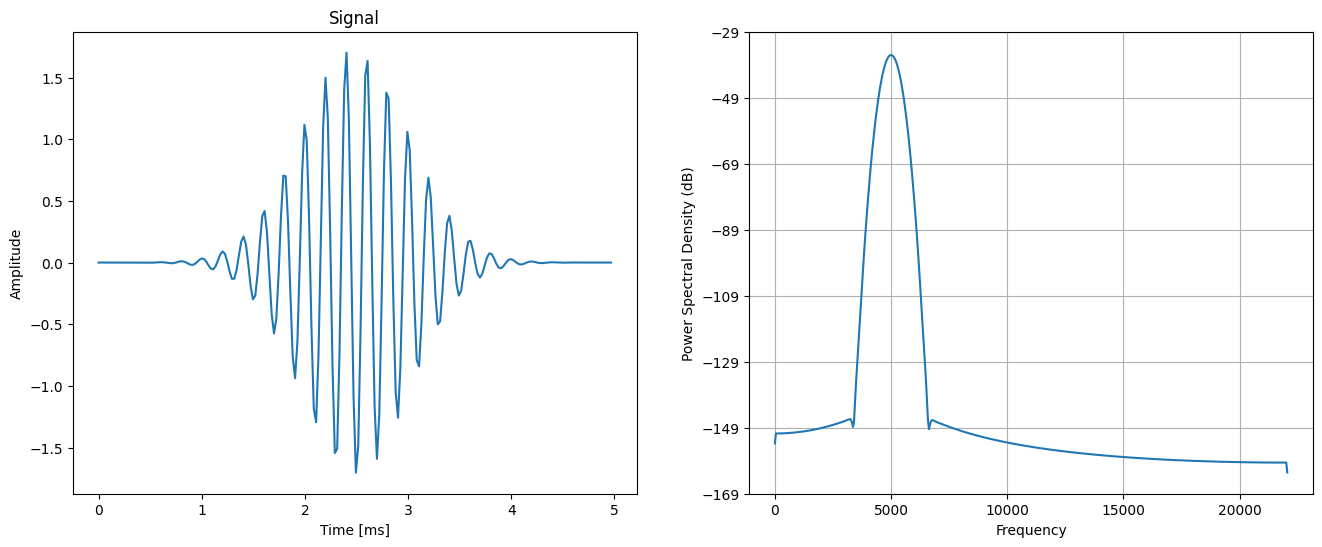

In [5]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs: tuple[plt.Axes, plt.Axes] # type: ignore
axs[0].plot(np.arange(sig_len)/sampling_rate*1000, sig)
axs[0].set_title('Signal')
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('Amplitude')
axs[1].psd(sig, NFFT=1024, Fs=sampling_rate, scale_by_freq=False)
plt.show()

### (2) Put the signal in the background noise at any time you like. Then, plot the PSD of the background and the signal+background. Can you spot the signal in the PSD?

##### Do NOT multiply the signal by any factor. Add them in a pure additive way.

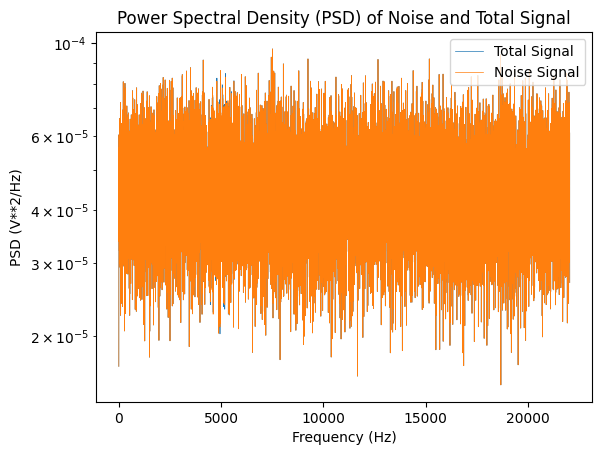

In [7]:
bkg_and_signal = bkg.copy()

# time in which the signal is injected, in seconds (s)
signal_time = 3
starting_index = signal_time * sampling_rate
for i in range(sig_len):
    bkg_and_signal[starting_index+i] = bkg_and_signal[starting_index+i]+sig[i]

# Using the same method as the last project, plot the PSD using Welch's method
f_total, Pxx_den_total = welch(bkg_and_signal, sampling_rate, nperseg=sampling_rate)
f_noise, Pxx_den_noise = welch(bkg, sampling_rate, nperseg=sampling_rate)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.title("Power Spectral Density (PSD) of Noise and Total Signal")
PSD_total = plt.semilogy(f_total, Pxx_den_total, linewidth=0.5, label="Total Signal")
PSD_noise = plt.semilogy(f_noise, Pxx_den_noise, linewidth=0.5, label="Noise Signal")

legend = plt.legend(loc="upper right")

With the foresight that the signal is placed at $5000 \text{ Hz}$, we see that at a frequency of around $5000 \text{ Hz}$ the Power Spectral Densities (PSDs) of the total signal and the background noise signal do not completely overlap. Looking closely enough, one can see some remnants of the total energy (in blue) that do not overlap with the noise signal. The region of non-overlap is relatively small, however.

#### (bonus-1) As the signal is t-dependent, how could you find the signal more efficiently? Make another sample with 3x signal amplitude, and spot the signal visually.

hint0: this is only a bonus :)

hint1: you know where to look for it: 5kHz at the time you placed it.

hint2: some parameters may need some finetuning to make it visible.

Since the signal will be amplified, and the signal is a time-dependent quantity it may be obvious from the graph that a signal was injected. Let us first plot the signal vs. time graph.

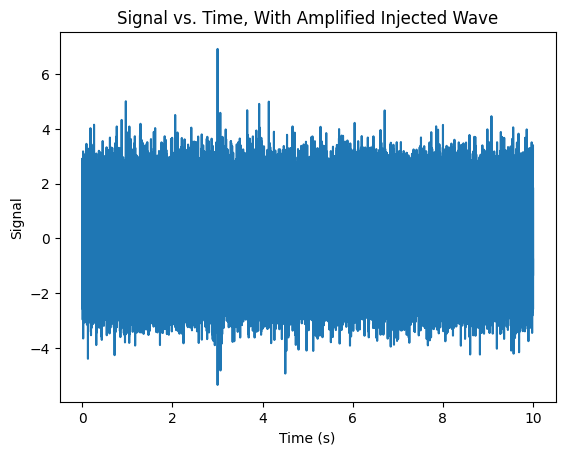

In [9]:
bkg_and_signal2 = bkg.copy()

signal_amplitude_factor = 3
for i in range(sig_len):
    bkg_and_signal2[starting_index+i] = bkg_and_signal2[starting_index+i] + signal_amplitude_factor * sig[i]

# Plotting signal vs. time, where the time is in seconds (s)
times_1 = np.linspace(0, bkg_len/sampling_rate, bkg_len)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Signal vs. Time, With Amplified Injected Wave")
amplified_plot = plt.plot(times_1, bkg_and_signal2)

Due to the large increase in the signal, it becomes quite clear that there is a signal around $\approx 3 \text{ s}$, where the amplitude is abnormally large. Another option is to plot the PSD, with the ambition that a larger amplitude will render the PSD at $5000 \text{ Hz}$ stronger.

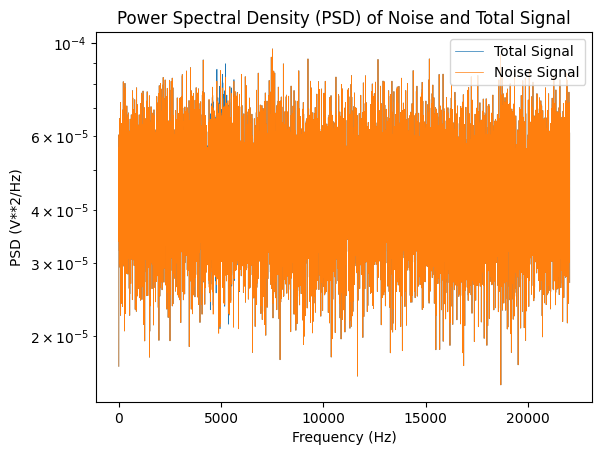

In [11]:
f_total, Pxx_den_total = welch(bkg_and_signal2, sampling_rate, nperseg=sampling_rate)
f_noise, Pxx_den_noise = welch(bkg, sampling_rate, nperseg=sampling_rate)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.title("Power Spectral Density (PSD) of Noise and Total Signal")
PSD_total = plt.semilogy(f_total, Pxx_den_total, linewidth=0.5, label="Total Signal")
PSD_noise = plt.semilogy(f_noise, Pxx_den_noise, linewidth=0.5, label="Noise Signal")

legend = plt.legend(loc="upper right")

To find the question signal, we can used the matched filter technique. The matched filter is a filter that maximizes the signal-to-noise ratio (SNR) of a signal with known shape. The matched filter is the cross-correlation of the template signal with the signal+background. You can read more at the [Wikipedia page](https://en.wikipedia.org/wiki/Matched_filter).

To apply the matched filter, in this case, just use the signal as the template, and apply cross-correlation of it with the signal+background.

Remark: The cross-correlation is the convolution of the signal+background with the time-reversed signal. You can do it using the `np.correlate` function, or the `np.convolve` function with signal in the reverse order.

### (3) Using matched filter, find the signal in the signal+background sample in time domain (when is it?).

First, apply the matched filter to the signal+background sample.

Then, estimate the noise in the filtered signal. You can use a part of the filtered data that you know that there is no signal. Take the standard deviation of this part as the noise level.

Finally, plot the SNR of the filtered signal. The SNR is the ratio of the amplitude of the filtered signal to the noise level. What is the SNR for the signal provided?

Remark: depending on the context, SNR can be defined in power density, which is proportional to the square of the amplitude.

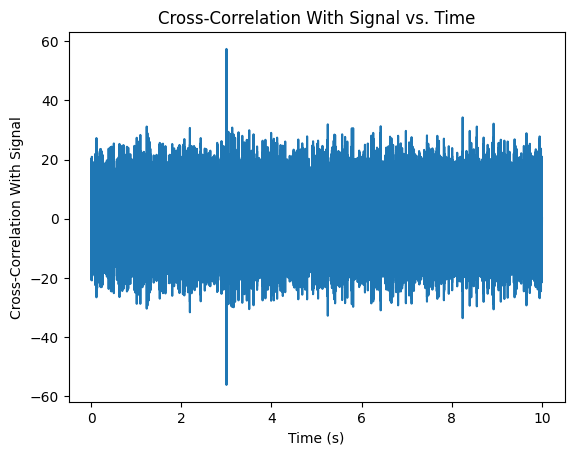

In [13]:
# Apply the cross-correlation between the background and signal with the template (the signal).
filtered_output_1 = np.correlate(bkg_and_signal, sig, "same")

# Plot the cross-correlation vs. time
plt.xlabel("Time (s)")
plt.ylabel("Cross-Correlation With Signal")
plt.title("Cross-Correlation With Signal vs. Time")
cross_correlation_plot = plt.plot(times_1, filtered_output_1)

By inspecting the graph, we see that there is a clear cross-correlation between the total signal and the sinusoidal signal at around $\approx \text{ 3 
s}$, which indicates that a signal was injected at that time. Let us now find the noise and the signal-to-noise ratio (SNR) in the suggested manner.

The standard deviation of the cross-correlation (the noise) is approximately 7.97763.
The SNR for the signal provided is approximately 7.191.


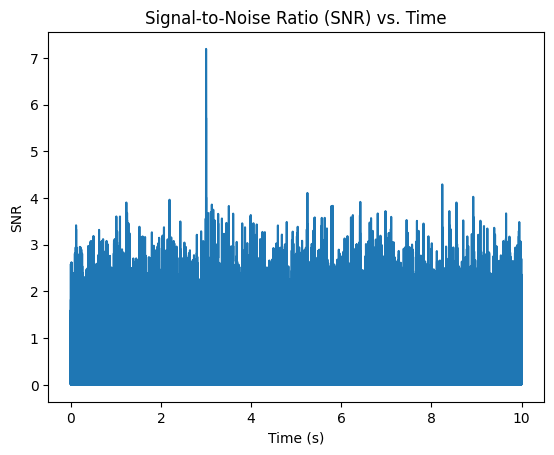

In [15]:
# We will examine the standard deviation between t=4s and t=8s.
start_time = 4
end_time = 8
sigma_1 = np.std(filtered_output_1[start_time*sampling_rate:end_time*sampling_rate])
print("The standard deviation of the cross-correlation (the noise) is approximately " + str(np.round(sigma_1, decimals=5)) + ".")

# Finally, we plot the signal-to-noise ratio
snr_1 = np.abs(filtered_output_1)/sigma_1
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.title("Signal-to-Noise Ratio (SNR) vs. Time")
SNR_plot_1 = plt.plot(times_1, snr_1)

snr_max = np.max(snr_1)
print("The SNR for the signal provided is approximately " + str(np.round(snr_max, decimals=3)) + ".")

As can be seen above, we are quite confident that the injected signal lies around $t=3 \text{ s}$, as the signal-to-noise ratio is by far the highest there.

### (4) New let get some real data and try to find a signal in it. Also, in this case, the noise is no longer uniform in frequency domain, and we can do the matched filter in the frequency domain to get a better result.

The data files `data_w_signal.hdf5` contains a time series measured from [LIGO](https://www.wikipedia.org/wiki/LIGO) (Laser Interferometer Gravitational-Wave Observatory). This data is a 4096 Hz time series with 16 seconds of duration. The signal is a chirp, that is a sinusoidal wave with a frequency increasing linearly in time.



For some background on what the signal source is: [Homework from the Last Year](https://github.com/Caltech-ph2x/ph21/files/14132007/assignments_Ph21_Ph21.3_LIGO_Inspiral.pdf).

**Only as a reference, you don't need to do the homework from last year ;)**

In [17]:
with h5.File('./data/data_w_signal.hdf5') as f:
    data = np.array(f['strain/Strain'])
with h5.File('./data/template.hdf5') as f:
    signal_template = np.array(f['strain/Strain'])

sampling_rate = 4096

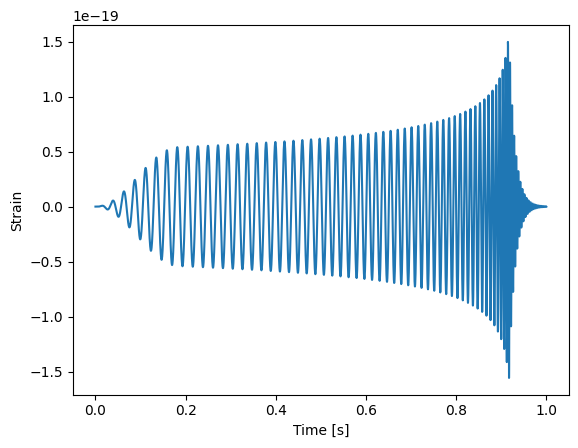

In [19]:
plt.plot(np.arange(len(signal_template))/sampling_rate, signal_template)
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.show()

Let's visualize the signal on a spectrogram. The spectrogram is a time-frequency representation of a time series. It is a 2D plot where the x-axis is the time, the y-axis is the frequency, and the color is the power density. You can use the `plt.specgram` function to plot the spectrogram.

As the chirp increases in frequency, you can see a ascending line in the spectrogram. The chirp is the signal we want to find.

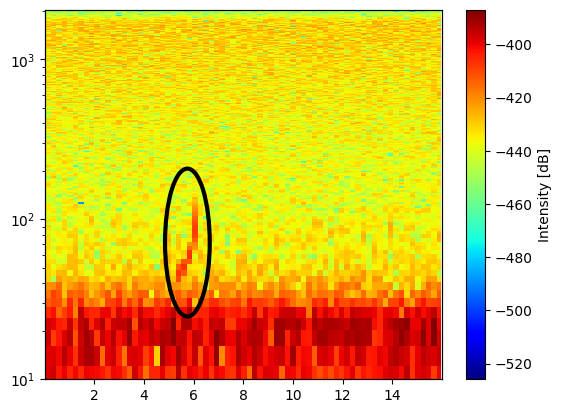

In [21]:
circle = mpl.patches.Ellipse((5.75, 0.37), 1.8,0.4,lw=3, color='k', fill=False) # type: ignore

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.set_yticks(())
ax2.add_patch(circle)
ax1.specgram(data, NFFT=1024, Fs=sampling_rate, label='Data', cmap='jet', mode='psd')
ax1.set_yscale('log')
ax1.set_ylim(10, 2048)
plt.colorbar(label='Intensity [dB]', mappable=ax1.get_children()[0]) # type: ignore
plt.show()

#### (4-1) Assume there is **no** signal presenting in **first 5-seconds** of the data. With the time-domain matched filter method we have just done, plot the SNR of the filtered signal. What is the SNR obtained this way?

#### After plotting out the SNR, do you see any other signal-like feature? (Other than the one around t=6s)

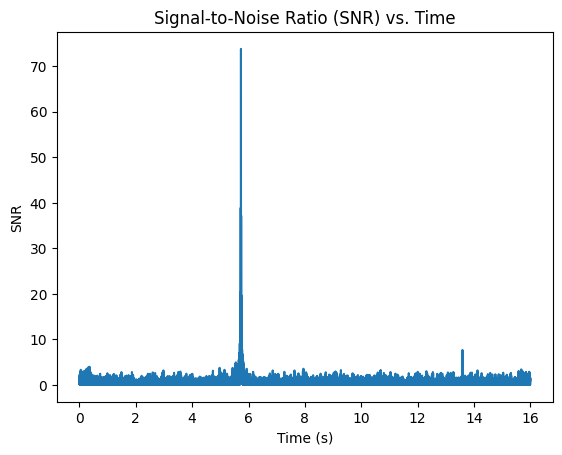

In [23]:
# Apply the cross-correlation between the background and signal with the template (the signal).
filtered_output_2 = np.correlate(data, signal_template, "same")
times_2 = np.linspace(0, len(data)/sampling_rate, len(data))

# We calculate the standard deviation from the data from the first 5 seconds, which is assumed to have no signal
start_time = 0
end_time = 5
sigma_2 = np.std(filtered_output_2[start_time*sampling_rate:end_time*sampling_rate])

# Finally, we plot the signal-to-noise ratio
snr_2 = np.abs(filtered_output_2)/sigma_2
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.title("Signal-to-Noise Ratio (SNR) vs. Time")
SNR_plot_2 = plt.plot(times_2, snr_2)




By examining the signal-to-noise ratio, we see that there is clearly a large signal around $t=6 \text{ s}$, with a SNR of approximately $73.80$. However, there is also a noticable signal around $t=13.5 \text{ s}$, where the SNR is significantly high as well ($\approx 7.68$), although not nearly as high as the first.

In [25]:
# There is a signal-like feature at round 13.5s.
# SNRs for the two signal-like features are printed below.

print("The first peak has a maximum SNR of " + str(np.max(snr_2)) + " and the second peak has a maximum SNR of " + str(np.max(snr_2[-3*4096:]))+ ".")

The first peak has a maximum SNR of 73.80047144782485 and the second peak has a maximum SNR of 7.676770274106984.


#### (4-2) Now, make a psd of the background region (first 5s of data). Use 4096 frequency bins, estimate the noise power for each frequency bin and plot the PSD.

Hint: `plt.psd` is a useful function that will plot the psd, and returns the power density and the frequency bins, with Welch's method applied. It can be very useful for this task.

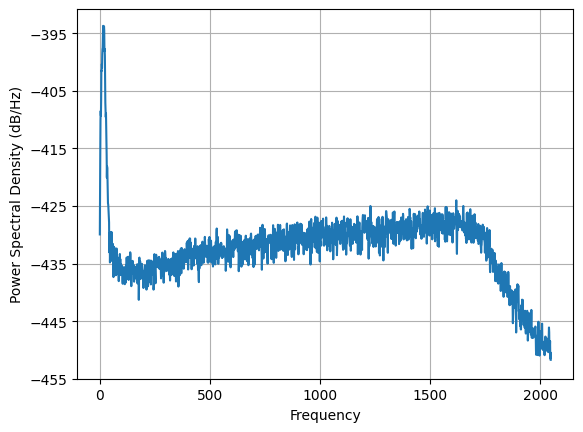

In [27]:
# Plot the psd only for the first 5 seconds. NOTE: the FFT itself has NFFT=4096 frequency bins, but the PSD only includes the frequency values >= 0
# and so there are only 2049 relevant frequencies
Pxx_chirp, f_chirp = plt.psd(data[:5*sampling_rate], NFFT=4096, Fs=sampling_rate, noverlap=2048)

In order to estimate the noise power from each frequency bin, we multiply the width of the bin with the power. Because the sampling rate and the number of bins are both $4096$, the width of each bin is $1 \text{ Hz}$. This means that the noise power for each frequency bin is equal to the $\text{Pxx}_{chirp}$ values (in $dB$), where the decibals are relative to a reference power of $P_0 = 1W$.

Apply the "optimal matched filter" mentioned in https://gwosc.org/tutorial_optimal/ :

1. Pad the signal template with zero entries at the end to match the length of the data
    - Think: why?
2. Take FFT of the padded template signal $S(\omega)$ and the data $X(\omega)$
3. Multiply the FFT of the data by the complex conjugate of the FFT of the template, then divide the product by the PSD of the background noise's power spectrum $S_n(\omega)$: evaluate $\frac{X(\omega)S^*(\omega)}{S_n(\omega)}$.
    - The number of bins is different for the spectrums of the data, signal template and power. Use `np.interp` to interpolate the power spectrum to the same frequency bins as the signal template and data.
    - Be careful: np.fft.fft outputs frequency from -f_s/2 to f_s/2, and the PSD is only with positive frequency.
4. Take the inverse FFT of the result. This is the optimal matched filter output in the time domain.
5. Normalize the result again by the standard deviation of the noise, the same as what we did in the time domain matched filter.


Hint: you can refer to the solution in the tutorial for this question.

If you feel like it, let'ss do this step by step.
First, pad the signal template with trailing zeros, and, get the FFT for the signal template and the data. You may use `np.concatenate` with `np.zeros` to pad the signal template, and `numpy` or `scipy` to compute the FFT.

In either case, get the corresponding frequencies for the FFT outputs, as we will need them to interpolate the PSD.

In [29]:
# Pad signal template with trailing zeros
pad = np.zeros(data.size - signal_template.size)
padded_signal_template = np.append(signal_template, pad)

# Take the Fourier transforms of the signal template and the data
data_fft = fft(data)
signal_template_fft = fft(padded_signal_template)

With `np.interp`, interpolate the PSD to the same frequency bins as the signal template and data.
- Be careful on the frequency range of the PSD and the FFT outputs. Are they the same?

In [31]:
# The data and signal template FFTs each have 65536 elements, while the Pxx_chirp from before only has 2049. Therefore we interpolate with
# the default numpy linear interpolation, interpolating the power spectrum to the same frequency bins as the signal template and data
# Code inspired by https://gwosc.org/tutorial_optimal/.

datafreq = fftfreq(data.size, d=1/sampling_rate)
power_vec = np.interp(datafreq, f_chirp, Pxx_chirp)

Evaluate $Y(\omega)=\frac{X(\omega)S^*(\omega)}{S_n(\omega)}$. Essentially, we are evaluating the output in the frequency domain $Y(\omega)=X(\omega)H(\omega)$ where $H(\omega)=\frac{S^*(\omega)}{S_n(\omega)}$ is the optimal filter in the frequency domain. Here, $S_n(\omega)$ represents the power spectral density. Then, we take the inverse fourier transform to produce the output in the time domain.

In [33]:
# Calculating the matched filter output
matched_filter = signal_template_fft.conjugate() / power_vec
optimal_output = data_fft * matched_filter

# We now take the inverse fourier transform of the matched filter output, as suggested in step 4 above
optimal_time = ifft(optimal_output)

Evaluate the background noise level in the filtered results with the same method as in the time domain matched filter: take the first 5-second as background region, take the standard deviation, and divide the results by it, then take absolute value to get the SNR.

In [35]:
# Calculate the standard deviation and the signal-to-noise ratio in an analogous manner to before
sigma_3 = np.std(optimal_time[:5*sampling_rate])
snr_3 = np.abs(optimal_time)/sigma_3

Plot the obtained SNR. What is the SNR obtained this way? Is it better than the time domain matched filter?

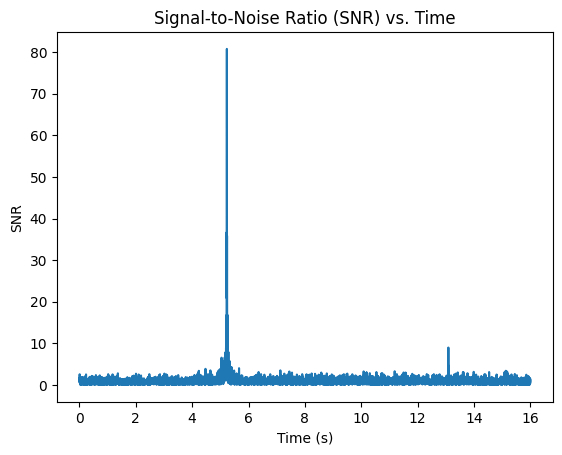

In [37]:
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.title("Signal-to-Noise Ratio (SNR) vs. Time")
SNR_plot_3 = plt.plot(times_2, snr_3)

# There is a signal-like feature at around 13.5s.
# SNRs for the two signal-like features are as shown.

In [39]:
# There is a signal-like feature at round 13.5s.
# SNRs for the two signal-like features are printed below.

print("The first peak has a maximum SNR of " + str(np.max(snr_3)) + " and the second peak has a maximum SNR of " + str(np.max(snr_3[-3*4096:]))+ ".")

The first peak has a maximum SNR of 80.78548490563499 and the second peak has a maximum SNR of 8.987555690297768.


The results obtained here in the frequency domain seem slightly better than those obtained in the time domain. For example, for the first and second peak, the signal to noise ratio is higher than directly applying the time domain matched filter ($80.785 \text{ vs. } 73.800$ and $8.988 \text{ vs. } 7.677$, respectively). Another difference is that the signals appear to be detected earlier using this method. If we look at the spectrogram, we see that indeed the largest, first signal begins to become nascent at closer to $5\text{ s}$ than $6\text{ s}$, which the frequency domain analysis picks up on, but the time domain analysis does not.

Remark: results of the optimal matched filter here may be sensitive to the estimated background PSD. In this particular case, changing the way PSD is computed (e.g., method, window, overlap, # of bins) may change the result.

### (5-optional) How would you say if the signal(s) you found in 4-1 and 4-2 are "real" or not?

Due to the large signal-to-noise ratio in the first signal at approximately $t=6 \text{ s}$, we can be confident that the signal is real, as long as there are no anomalies in detection (i.e. picking up incorrect signals that are not from gravitational waves, etc). Additionally, if there is some physical interpretation of the signals (e.g. why certain signals are weaker than others), this also corroborates the reality of the signals. We can and should, of course, also check for statistical significance of the results, although it is rather clear that these results are statistically significant.